# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_049  A0A0J9YX35                 17.063
Sample_022  A0A087WZM2;D6RHI9;O00584   16.659
Sample_168  Q9NTU7                     17.118
Sample_079  P24593                     17.350
Sample_057  P13671                     18.763
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups                                                               
Sample_064  O75339                                                                          14.049
Sample_040  A0A0U1RR32;A0A0U1RRH7;P04908;P0C0S8;P20671;Q7L7L0;Q93077;Q96KK5;Q99878;Q9BTM1   16.448
Sample_185  P67936                                                                          15.295
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.080
            A0A075B6Q5                 11.780
            A0A075B6R2                 13.540
            A0A075B6S5                 11.911
            A0A087WSY4                 12.617
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.524
            Q9UI40;Q9UI40-2            11.074
            Q9UIW2                     13.260
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.241
            Q9UP79                     14.030
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.786,15.050,16.842,19.863,15.840,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.672,19.067,...,15.528,15.576,13.873,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.878,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.005,17.705,17.039,15.743,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.927,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.473,15.345,17.084,18.708,14.249,19.433,11.363,10.936
Sample_207,15.739,16.877,15.469,16.898,13.361,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.080,...,16.012,15.178,14.416,15.050,16.842,19.863,11.794,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.553,19.067,16.188,...,15.528,15.576,12.872,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.980,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.115,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.150,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.491,15.345,17.084,18.708,14.249,19.433,12.823,11.597
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 366.00it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.34it/s]

100%|██████████| 3/3 [00:00<00:00,  2.83it/s]

100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.61it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.34it/s]

100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.62it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.53it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.99it/s]

100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.10it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.82it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.30it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.08it/s]

100%|██████████| 6/6 [00:01<00:00,  2.56it/s]

100%|██████████| 6/6 [00:01<00:00,  3.00it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.16it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.05it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.60it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.30it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.08it/s]

100%|██████████| 7/7 [00:02<00:00,  2.50it/s]

100%|██████████| 7/7 [00:02<00:00,  3.02it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.76it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.25it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.93it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.69it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.21it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.60it/s]

100%|██████████| 8/8 [00:02<00:00,  2.13it/s]

100%|██████████| 8/8 [00:02<00:00,  2.81it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.05it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.82it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.99it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.97it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.06it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.16it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.24it/s]

100%|██████████| 9/9 [00:02<00:00,  3.27it/s]

100%|██████████| 9/9 [00:02<00:00,  3.17it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.52it/s]

 30%|███       | 3/10 [00:00<00:01,  4.87it/s]

 40%|████      | 4/10 [00:00<00:01,  4.15it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.89it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.67it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.57it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.46it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.36it/s]

100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.58it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.46it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.98it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.53it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.70it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.43it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.27it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.22it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.39it/s]

100%|██████████| 11/11 [00:04<00:00,  2.45it/s]

100%|██████████| 11/11 [00:04<00:00,  2.73it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.71it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.90it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.39it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.24it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.35it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.37it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.47it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.56it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.57it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.65it/s]

100%|██████████| 12/12 [00:04<00:00,  2.76it/s]

100%|██████████| 12/12 [00:04<00:00,  2.60it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.74it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.84it/s]

 31%|███       | 4/13 [00:01<00:02,  3.32it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.99it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.00it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.89it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.73it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.79it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.87it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.95it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.07it/s]

100%|██████████| 13/13 [00:04<00:00,  3.05it/s]

100%|██████████| 13/13 [00:04<00:00,  3.08it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.32it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.07it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.29it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.22it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.17it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.07it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.04it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.96it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.98it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.05it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.10it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.14it/s]

100%|██████████| 14/14 [00:04<00:00,  3.21it/s]

100%|██████████| 14/14 [00:04<00:00,  3.22it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.47it/s]

 20%|██        | 3/15 [00:00<00:03,  3.75it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.44it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.28it/s]

 40%|████      | 6/15 [00:01<00:02,  3.00it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.92it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.02it/s]

 60%|██████    | 9/15 [00:02<00:02,  3.00it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.05it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.58it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.36it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.34it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.30it/s]

100%|██████████| 15/15 [00:05<00:00,  2.30it/s]

100%|██████████| 15/15 [00:05<00:00,  2.74it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.061 0.026          0.778 0.322       0.119   
2             0.006 0.006      0.075 0.033          0.691 0.089       0.633   
3             0.006 0.004      0.061 0.022          0.778 0.100       0.720   
4             0.005 0.004      0.059 0.019          0.774 0.093       0.776   
5             0.008 0.007      0.080 0.033          0.772 0.093       0.776   
6             0.005 0.004      0.068 0.023          0.833 0.086       0.780   
7             0.006 0.005      0.065 0.024          0.837 0.090       0.780   
8             0.006 0.005      0.070 0.029          0.822 0.085       0.804   
9             0.006 0.005      0.077 0.035          0.824 0.085       0.807   
10            0.007 0.006      0.080 0.039          0.817 0.084       0.814   
11            0.006 0.005      0.063 0.026          0.815 0.084       0.810   
12            0.005 0.004      0.062 0.022          0.816 0.083       0.810   
13            0.008 0.006      0.072 0.030          0.813 0.085       0.809   
14            0.008 0.007      0.082 0.034          0.812 0.087       0.808   
15            0.005 0.003      0.075 0.031          0.815 0.089       0.809   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.198 0.127                  0.551 0.041        0.850   
2          0.106   0.655 0.079                  0.711 0.060        0.795   
3          0.103   0.743 0.080                  0.782 0.063        0.871   
4          0.107   0.770 0.077                  0.803 0.065        0.874   
5          0.109   0.769 0.078                  0.802 0.065        0.870   
6          0.091   0.802 0.071                  0.831 0.058        0.895   
7          0.094   0.803 0.073                  0.833 0.061        0.895   
8          0.108   0.809 0.079                  0.838 0.066        0.913   
9          0.104   0.812 0.077                  0.840 0.065        0.912   
10         0.101   0.812 0.076                  0.839 0.065        0.911   
11         0.100   0.809 0.076                  0.837 0.065        0.910   
12         0.105   0.810 0.076                  0.838 0.064        0.909   
13         0.102   0.807 0.075                  0.835 0.063        0.907   
14         0.102   0.806 0.075                  0.835 0.063        0.905   
15         0.094   0.808 0.073                  0.836 0.062        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.821 0.088        210.000 0.000  
2          0.067                  0.758 0.086        210.000 0.000  
3          0.057                  0.836 0.077        210.000 0.000  
4          0.056                  0.839 0.077        210.000 0.000  
5          0.057                  0.833 0.079        210.000 0.000  
6          0.053                  0.876 0.062        210.000 0.000  
7          0.054                  0.876 0.065        210.000 0.000  
8          0.048                  0.903 0.050        210.000 0.000  
9          0.050                  0.903 0.052        210.000 0.000  
10         0.051                  0.900 0.054        210.000 0.000  
11         0.051                  0.898 0.054        210.000 0.000  
12         0.051                  0.899 0.053        210.000 0.000  
13         0.052                  0.898 0.053        210.000 0.000  
14         0.053                  0.894 0.054        210.000 0.000  
15         0.053                  0.900 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 570.42it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.91it/s]

100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.55it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.65it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.39it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.70it/s]

100%|██████████| 5/5 [00:01<00:00,  2.70it/s]

100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.33it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.49it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.07it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.07it/s]

100%|██████████| 6/6 [00:02<00:00,  2.11it/s]

100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.93it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.12it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.37it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.01it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.91it/s]

100%|██████████| 7/7 [00:02<00:00,  2.93it/s]

100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.45it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.01it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.63it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.52it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.63it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.66it/s]

100%|██████████| 8/8 [00:03<00:00,  2.46it/s]

100%|██████████| 8/8 [00:03<00:00,  2.65it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.01it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.78it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.30it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.88it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.89it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.91it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.78it/s]

100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

100%|██████████| 9/9 [00:03<00:00,  2.87it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.66it/s]

 30%|███       | 3/10 [00:00<00:01,  4.13it/s]

 40%|████      | 4/10 [00:01<00:01,  3.12it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.78it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.89it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.98it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.94it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.94it/s]

100%|██████████| 10/10 [00:03<00:00,  2.67it/s]

100%|██████████| 10/10 [00:03<00:00,  2.99it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.94it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.55it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.06it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.90it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.73it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.70it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.77it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.80it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.80it/s]

100%|██████████| 11/11 [00:03<00:00,  2.47it/s]

100%|██████████| 11/11 [00:03<00:00,  2.79it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.35it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.95it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.84it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.82it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.75it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.72it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.73it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.78it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.84it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.82it/s]

100%|██████████| 12/12 [00:04<00:00,  2.32it/s]

100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.41it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.45it/s]

 31%|███       | 4/13 [00:01<00:02,  3.16it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.85it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.75it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.76it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.83it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.72it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.75it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.11it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  1.84it/s]

100%|██████████| 13/13 [00:05<00:00,  1.78it/s]

100%|██████████| 13/13 [00:05<00:00,  2.37it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.32it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.87it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.34it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.99it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.98it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.96it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.04it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.01it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.66it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.65it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.10it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.01it/s]

100%|██████████| 14/14 [00:05<00:00,  1.91it/s]

100%|██████████| 14/14 [00:05<00:00,  2.53it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.71it/s]

 20%|██        | 3/15 [00:00<00:03,  3.48it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.11it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.99it/s]

 40%|████      | 6/15 [00:01<00:03,  2.92it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.84it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.53it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.51it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.57it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.59it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.63it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.47it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.54it/s]

100%|██████████| 15/15 [00:05<00:00,  2.62it/s]

100%|██████████| 15/15 [00:05<00:00,  2.74it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.007      0.068 0.035          0.087 0.248       0.009   
2             0.006 0.005      0.070 0.030          0.812 0.091       0.768   
3             0.007 0.006      0.075 0.030          0.809 0.090       0.767   
4             0.005 0.003      0.074 0.032          0.820 0.090       0.779   
5             0.006 0.004      0.070 0.026          0.793 0.093       0.783   
6             0.006 0.005      0.076 0.028          0.812 0.091       0.781   
7             0.007 0.006      0.088 0.033          0.794 0.094       0.778   
8             0.005 0.004      0.067 0.027          0.790 0.097       0.773   
9             0.005 0.003      0.063 0.023          0.790 0.097       0.778   
10            0.006 0.004      0.064 0.024          0.811 0.090       0.791   
11            0.005 0.004      0.069 0.025          0.804 0.095       0.787   
12            0.007 0.005      0.071 0.026          0.816 0.090       0.791   
13            0.005 0.003      0.057 0.017          0.816 0.091       0.790   
14            0.006 0.005      0.062 0.023          0.816 0.092       0.807   
15            0.004 0.000      0.049 0.011          0.825 0.091       0.802   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.868   
2          0.107   0.785 0.080                  0.818 0.064        0.885   
3          0.107   0.782 0.078                  0.816 0.063        0.880   
4          0.111   0.794 0.081                  0.826 0.065        0.880   
5          0.101   0.783 0.075                  0.815 0.063        0.879   
6          0.101   0.791 0.075                  0.823 0.062        0.878   
7          0.108   0.780 0.080                  0.813 0.065        0.877   
8          0.109   0.776 0.079                  0.809 0.065        0.875   
9          0.103   0.778 0.077                  0.811 0.064        0.875   
10         0.099   0.797 0.073                  0.827 0.062        0.911   
11         0.103   0.791 0.078                  0.822 0.065        0.910   
12         0.102   0.799 0.075                  0.829 0.063        0.912   
13         0.107   0.797 0.076                  0.828 0.063        0.912   
14         0.105   0.807 0.076                  0.835 0.065        0.909   
15         0.098   0.809 0.071                  0.837 0.060        0.911   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.835 0.087        210.000 0.000  
2          0.050                  0.868 0.061        210.000 0.000  
3          0.050                  0.860 0.063        210.000 0.000  
4          0.052                  0.860 0.065        210.000 0.000  
5          0.053                  0.856 0.067        210.000 0.000  
6          0.055                  0.854 0.067        210.000 0.000  
7          0.055                  0.852 0.068        210.000 0.000  
8          0.054                  0.855 0.065        210.000 0.000  
9          0.054                  0.854 0.065        210.000 0.000  
10         0.049                  0.894 0.055        210.000 0.000  
11         0.050                  0.894 0.056        210.000 0.000  
12         0.048                  0.893 0.055        210.000 0.000  
13         0.046                  0.893 0.054        210.000 0.000  
14         0.047                  0.890 0.053        210.000 0.000  
15         0.046                  0.893 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 990.39it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 15.05it/s]

100%|██████████| 2/2 [00:00<00:00, 14.75it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 17.81it/s]

100%|██████████| 3/3 [00:00<00:00, 14.42it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.22it/s]

100%|██████████| 4/4 [00:00<00:00, 16.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 17.87it/s]

100%|██████████| 5/5 [00:00<00:00, 14.42it/s]

100%|██████████| 5/5 [00:00<00:00, 14.82it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 26.42it/s]

100%|██████████| 6/6 [00:00<00:00, 18.75it/s]

100%|██████████| 6/6 [00:00<00:00, 19.52it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.42it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.42it/s]

100%|██████████| 7/7 [00:00<00:00, 15.82it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 18.41it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 15.31it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 14.30it/s]

100%|██████████| 8/8 [00:00<00:00, 14.54it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.17it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 17.32it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.72it/s]

100%|██████████| 9/9 [00:00<00:00, 17.42it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 28.70it/s]

 60%|██████    | 6/10 [00:00<00:00, 21.74it/s]

 90%|█████████ | 9/10 [00:00<00:00, 20.86it/s]

100%|██████████| 10/10 [00:00<00:00, 20.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.56it/s]

 45%|████▌     | 5/11 [00:00<00:00, 16.52it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 17.21it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 17.82it/s]

100%|██████████| 11/11 [00:00<00:00, 16.68it/s]

100%|██████████| 11/11 [00:00<00:00, 17.03it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 27.80it/s]

 50%|█████     | 6/12 [00:00<00:00, 21.78it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 19.77it/s]

100%|██████████| 12/12 [00:00<00:00, 19.95it/s]

100%|██████████| 12/12 [00:00<00:00, 20.54it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 27.75it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 24.67it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 21.99it/s]

100%|██████████| 13/13 [00:00<00:00, 20.44it/s]

100%|██████████| 13/13 [00:00<00:00, 21.69it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 27.23it/s]

 50%|█████     | 7/14 [00:00<00:00, 21.95it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 21.41it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 20.22it/s]

100%|██████████| 14/14 [00:00<00:00, 21.38it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 29.33it/s]

 47%|████▋     | 7/15 [00:00<00:00, 18.83it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 14.26it/s]

 80%|████████  | 12/15 [00:00<00:00, 12.99it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 12.57it/s]

100%|██████████| 15/15 [00:01<00:00, 13.95it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.066 0.027          0.000 0.000       0.000   
2             0.006 0.005      0.066 0.026          0.601 0.143       0.352   
3             0.004 0.003      0.052 0.019          0.643 0.117       0.478   
4             0.004 0.002      0.048 0.010          0.686 0.103       0.565   
5             0.003 0.002      0.040 0.011          0.658 0.088       0.577   
6             0.003 0.001      0.042 0.017          0.700 0.092       0.630   
7             0.003 0.002      0.042 0.016          0.724 0.094       0.665   
8             0.004 0.001      0.048 0.009          0.700 0.090       0.663   
9             0.003 0.001      0.040 0.009          0.711 0.094       0.667   
10            0.003 0.001      0.039 0.013          0.703 0.093       0.677   
11            0.003 0.001      0.035 0.010          0.694 0.089       0.672   
12            0.002 0.000      0.028 0.005          0.697 0.089       0.682   
13            0.002 0.000      0.028 0.008          0.695 0.091       0.682   
14            0.002 0.000      0.027 0.000          0.701 0.082       0.684   
15            0.003 0.001      0.040 0.015          0.707 0.083       0.682   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.737   
2          0.097   0.432 0.096                  0.583 0.056        0.655   
3          0.108   0.541 0.096                  0.640 0.065        0.724   
4          0.133   0.612 0.106                  0.687 0.072        0.789   
5          0.111   0.610 0.087                  0.679 0.065        0.792   
6          0.130   0.657 0.098                  0.716 0.071        0.826   
7          0.118   0.686 0.087                  0.738 0.066        0.829   
8          0.104   0.675 0.075                  0.725 0.060        0.830   
9          0.109   0.682 0.080                  0.732 0.064        0.829   
10         0.107   0.684 0.082                  0.732 0.065        0.833   
11         0.111   0.677 0.082                  0.726 0.065        0.828   
12         0.121   0.684 0.089                  0.732 0.070        0.833   
13         0.122   0.681 0.086                  0.729 0.068        0.828   
14         0.109   0.687 0.074                  0.734 0.060        0.827   
15         0.111   0.688 0.076                  0.735 0.060        0.826   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.686 0.082        210.000 0.000  
2          0.072                  0.582 0.092        210.000 0.000  
3          0.075                  0.668 0.088        210.000 0.000  
4          0.073                  0.714 0.094        210.000 0.000  
5          0.069                  0.727 0.081        210.000 0.000  
6          0.062                  0.765 0.082        210.000 0.000  
7          0.057                  0.776 0.073        210.000 0.000  
8          0.059                  0.782 0.074        210.000 0.000  
9          0.060                  0.783 0.074        210.000 0.000  
10         0.058                  0.785 0.072        210.000 0.000  
11         0.057                  0.780 0.071        210.000 0.000  
12         0.057                  0.784 0.070        210.000 0.000  
13         0.059                  0.777 0.074        210.000 0.000  
14         0.059                  0.779 0.074        210.000 0.000  
15         0.058                  0.775 0.075 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,7,2
score_time,14,7,2
test_precision,7,15,7
test_recall,10,14,14
test_f1,10,15,15
test_balanced_accuracy,9,15,7
test_roc_auc,8,12,12
test_average_precision,8,10,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.59it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.34it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.78it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.41it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.80it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.74it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.97it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.19it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.27it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.28it/s]

100%|██████████| 12/12 [00:03<00:00,  3.38it/s]

100%|██████████| 12/12 [00:03<00:00,  3.43it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 28.16it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 24.36it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 22.22it/s]

100%|██████████| 12/12 [00:00<00:00, 22.88it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 11.21it/s]

 50%|█████     | 4/8 [00:00<00:00,  6.35it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  5.91it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  5.64it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  5.42it/s]

100%|██████████| 8/8 [00:01<00:00,  5.31it/s]

100%|██████████| 8/8 [00:01<00:00,  5.79it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


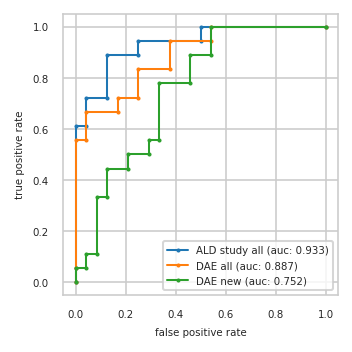

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.611   0.000 0.556   0.042 0.056
3          0.042 0.611   0.042 0.556   0.042 0.111
4          0.042 0.722   0.042 0.667   0.083 0.111
5          0.125 0.722   0.167 0.667   0.083 0.333
6          0.125 0.889   0.167 0.722   0.125 0.333
7          0.250 0.889   0.250 0.722   0.125 0.444
8          0.250 0.944   0.250 0.833   0.208 0.444
9          0.500 0.944   0.375 0.833   0.208 0.500
10         0.500 1.000   0.375 0.944   0.292 0.500
11         1.000 1.000   0.542 0.944   0.292 0.556
12           NaN   NaN   0.542 1.000   0.333 0.556
13           NaN   NaN   1.000 1.000   0.333 0.778
14           NaN   NaN     NaN   NaN   0.458 0.778
15           NaN   NaN     NaN   NaN   0.458 0.889
16           NaN   NaN     NaN   NaN   0.542 0.889
17           NaN   NaN     NaN   NaN   0.542 1.000
18           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P01597;P04432,Q9NX62,Q9UI40;Q9UI40-2
2,A0A0J9YX35,A0A1B0GV23;A0A1B0GVD5;A0A1B0GWE8;P07339,Q9NUQ9
3,P61981,Q6ZMP0;Q6ZMP0-2,P31321
4,P04075,P14174,P51688
5,P14174,P61981,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
6,P08294,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,Q9Y2T3;Q9Y2T3-3,P04075,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
8,None,P63104,Q96GD0


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


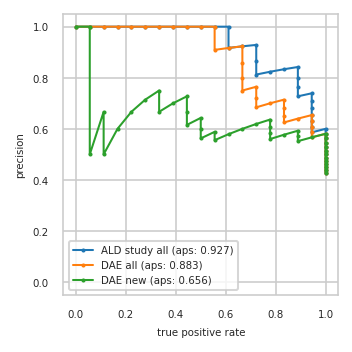

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.545 1.000
10         0.562 1.000     0.562 1.000     0.562 1.000
11         0.581 1.000     0.581 1.000     0.581 1.000
12         0.600 1.000     0.567 0.944     0.567 0.944
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.607 0.944     0.607 0.944     0.571 0.889
15         0.630 0.944     0.630 0.944     0.593 0.889
16         0.654 0.944     0.654 0.944     0.577 0.833
17         0.680 0.944     0.640 0.889     0.560 0.778
18         0.708 0.944     0.625 0.833     0.583 0.778
19         0.739 0.944     0.652 0.833     0.609 0.778
20         0.727 0.889     0.682 0.833     0.636 0.778
21         0.762 0.889     0.714 0.833     0.619 0.722
22         0.800 0.889     0.700 0.778     0.600 0.667
23         0.842 0.889     0.684 0.722     0.579 0.611
24         0.833 0.833     0.722 0.722     0.556 0.556
25         0.824 0.778     0.765 0.722     0.588 0.556
26         0.812 0.722     0.750 0.667     0.562 0.500
27         0.867 0.722     0.800 0.667     0.600 0.500
28         0.929 0.722     0.857 0.667     0.643 0.500
29         0.923 0.667     0.923 0.667     0.615 0.444
30         0.917 0.611     0.917 0.611     0.667 0.444
31         1.000 0.611     0.909 0.556     0.727 0.444
32         1.000 0.556     1.000 0.556     0.700 0.389
33         1.000 0.500     1.000 0.500     0.667 0.333
34         1.000 0.444     1.000 0.444     0.750 0.333
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


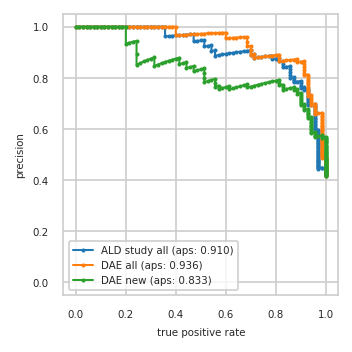

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


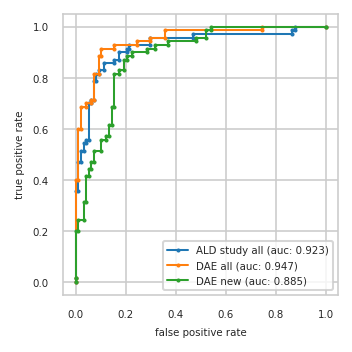

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}